# Kriging
This notebook shows the different visualizations of kriging. 

In [ ]:
import pandas as pd
import numpy as np
import os
import gstools as gs
from tqdm.contrib.concurrent import process_map
from krigin_imputation import ked_interpolation_gstools
import rasterio
import matplotlib.pyplot as plt

c:\Users\elwin\Desktop\MeteoThesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
df_raw = pd.read_csv("../data/filtered/merged_valais.csv")

In [64]:
df_raw = df_raw[df_raw['time']==202105101340].copy()
df_raw = df_raw.dropna(subset=['east', 'north', 'altitude', 'East', 'North'])
df = df_raw.copy()
df['east'] = df_raw['east']+2000000
df['north'] = df_raw['north']+1000000
df['wind_speed'] =  np.sqrt(df['East']**2 + df['North']**2)
known_points = df[['east', 'north', 'altitude', 'wind_speed']].values

In [65]:
with rasterio.open("../data/clean/valais_elevation.asc") as src:
    elevation_grid = src.read(1)
    transform = src.transform
    bounds = src.bounds
    height, width = elevation_grid.shape

    # Generate all (x, y) coordinates
    rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)

    # Build grid of unknown points: [east, north, altitude]
    unknown_points = np.column_stack([
        xs.flatten(),
        ys.flatten(),
        elevation_grid.flatten()
    ])

In [71]:
import rasterio

# Load wind atlas raster
with rasterio.open("../data/raw/WINDATLAS_SCHWEIZ_HEIGHT_LEVEL_50_CH_2018.tif") as drift_src:
    wind_atlas = drift_src.read(1)  # The drift raster values (e.g. wind speed at 50 m)
    drift_transform = drift_src.transform
    drift_crs = drift_src.crs


In [ ]:
known_points = df[['east', 'north', 'altitude', 'wind_speed']].values
mask_valid = ~np.isnan(unknown_points[:, 2])
unknown_points_valid = unknown_points[mask_valid]

In [ ]:
interpolated_values = ked_interpolation_gstools(known_points, unknown_points_valid)

In [74]:
# Assume station coordinates are in EPSG:2056 (same as the wind atlas)
station_coords = list(zip(df['east'], df['north']))

# Sample the drift values from the wind atlas raster at station locations
with rasterio.open("../data/raw/WINDATLAS_SCHWEIZ_HEIGHT_LEVEL_50_CH_2018.tif") as drift_src:
    drift_values = [val[0] for val in drift_src.sample(station_coords)]

df['wind_drift'] = drift_values

In [75]:
# Known data (stations): [x, y, wind_drift, variable]
known_points = df.dropna(subset=['precip', 'wind_drift'])[['east', 'north', 'wind_drift', 'precip']].values

In [77]:
# Shape of the full grid
grid_shape = elevation_grid.shape  # (height, width)

# Mask of valid elevation values
mask_valid = ~np.isnan(elevation_grid.flatten())

# Fill interpolated values into a full grid
full_grid = np.full(elevation_grid.size, np.nan)
full_grid[mask_valid] = interpolated_values

# Reshape to 2D for plotting
full_grid = full_grid.reshape(grid_shape)


In [78]:
from rasterio.transform import from_origin

# Save interpolated values into a 2D array
interpolated_raster = full_grid  # shape = (height, width)


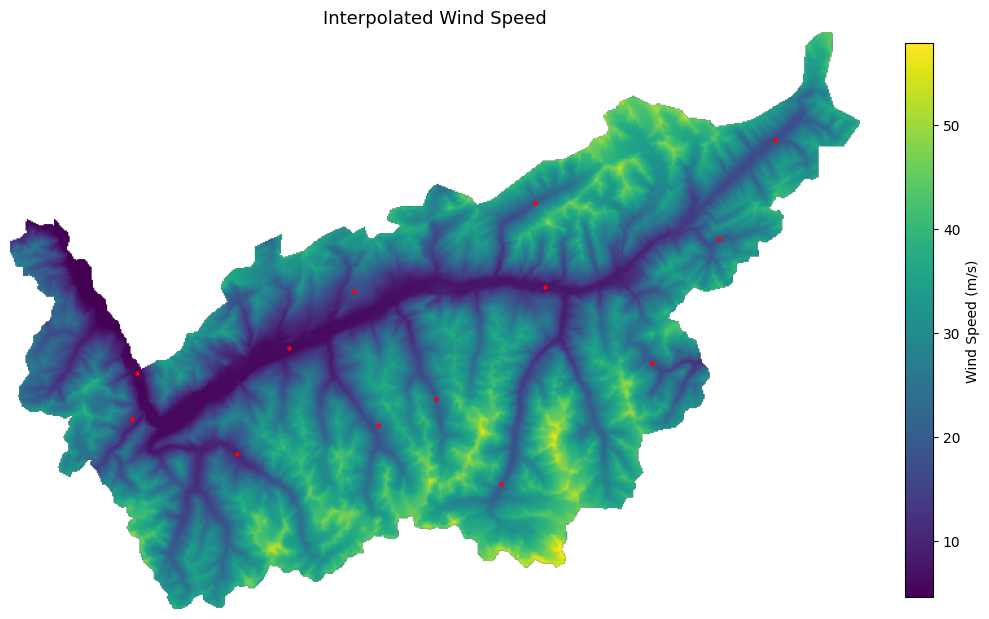

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))

# Store the image object returned by imshow
img = ax.imshow(
    interpolated_raster,
    cmap='viridis',
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    origin='upper'
)

ax.set_axis_off()

# Pass image to colorbar
plt.colorbar(img, ax=ax, label="Wind Speed (m/s)", fraction=0.03)

#add stations
plt.scatter(df['east'], df['north'], c='red', s=5, label='Stations')

plt.title("Interpolated Wind Speed", fontsize=13)
plt.tight_layout()
plt.savefig('../report/figures/wind_krig.pdf')
plt.show()